In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib import rc
from ellipse import LsqEllipse
from math import comb
from matplotlib.patches import Ellipse
import scipy.optimize as sco
from scipy.optimize import fmin
from scipy.optimize import curve_fit
import scipy
import json
import glob
import os
import allantools
from tqdm.notebook import trange, tqdm
import warnings
from scipy.optimize import least_squares

warnings.filterwarnings("ignore")
rc('font',**{'family':'sans-serif','sans-serif':['Fira Sans'],'size':14,'style':'normal'})
rc('text', usetex=False)
BLUE = 'xkcd:pastel blue'
RED = 'xkcd:pastel red'
GREEN = 'xkcd:pastel green'
YELLOW ='xkcd:pastel yellow'
PURPLE = 'xkcd:pastel purple'
DBLUE = 'xkcd:light navy blue'
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=[BLUE, RED, GREEN, YELLOW,PURPLE,DBLUE])

c = 299792458
f0 = 429e12
h_const = 6.626e-34
og_directory = os.getcwd()

from scipy.optimize import curve_fit

def fit_sine(t, y, yerr=None):
    """
    Fit y(t) ≈ A * sin(2π f t + phi) + offset

    Parameters
    ----------
    t : array
        Time (or x) values.
    y : array
        Data values.
    yerr : array, optional
        1σ errors on y. If provided, weighted least-squares is used.

    Returns
    -------
    dict : best-fit parameters, 1σ errors, and model function.
    """
    def model(t, A, f, phi):
        return A * np.sin(2*np.pi*f*t + phi) 

    # --- crude guesses ---
    guess_A = (np.max(y) - np.min(y)) / 2
    guess_offset = 0
    
    # frequency guess from FFT
    freqs = np.fft.rfftfreq(len(t), d=(t[1]-t[0]))
    fft_mag = np.abs(np.fft.rfft(y - 0))
    guess_f = freqs[np.argmax(fft_mag[1:]) + 1] if len(freqs) > 1 else 1.0
    
    guess_phi = 0
    p0 = [guess_A, guess_f, guess_phi]

    # --- fit ---
    popt, pcov = curve_fit(
        model, t, y, p0=p0,
        sigma=yerr, absolute_sigma=True if yerr is not None else False
    )
    perr = np.sqrt(np.diag(pcov))

    names = ["amplitude", "frequency", "phase"]

    return {
        name: val for name, val in zip(names, popt)
    } | {
        f"{name}_err": err for name, err in zip(names, perr)
    } | {
        "model": lambda t: model(t, *popt)
    }


def allan_errors(frac_frequencies, allan_dev, tau, ramsey_time, dead_time,
                     method="oadev", noise_process="whitefm"):

        #Getting our common varibles needed
        n = len(frac_frequencies)
        m = tau/(ramsey_time+dead_time)      
        
        #Calculate edf for chi-squared calculation based on noise process
        if method == "oadev":
            if noise_process == "whitepm":
                edf = (n + 1)*(n - 2*m)/(2*(n - m))
            elif noise_process == "whitefm":
                edf = (4*m**4/(4*m**2+5))*(3*(n-1)/(2*m) - 2*(n-2)/n)
            else:
                print("Unable to calculate error for given error type")
                
        if method == "totdev":
            if noise_process == "whitepm" or noise_process=="whitefm":
                b = 1.50
                c= 0.0
                big_t = len(frac_frequencies)*(ramsey_time+dead_time) #Total measurement time
                edf = b*(big_t/tau) - c
            else:
                print("Unable to calculate error for given error type")
                
        else:
            if noise_process == "whitepm" or noise_process == "whitefm":
                edf = (n + 1)*(n - 2*m)/(2*(n - m))
            else:
                print("Unable to calculate error for given error type")
        
        #Calculating Chi Squared Table Values
        lower_chi = scipy.stats.chi2.isf(0.16, df=edf)
        upper_chi = scipy.stats.chi2.isf(0.84, df=edf)
        #Making sure to use variance in our calculations and report our CI in terms of deviataion
        lower_cutoff = allan_dev - np.sqrt(allan_dev**2*(edf/lower_chi))
        upper_cutoff = np.sqrt(allan_dev**2*(edf/upper_chi)) - allan_dev
        
        return(lower_cutoff, upper_cutoff)    



def monoExp(x,t):
    return np.exp(-(1/t) * x) 

def monoExpN(x,t,c):
    return c*np.exp(-(1/t) * x) 


def get_parent_dir(directory):
    import os
    return os.path.dirname(directory)
def QPN(tau,N,C,t_ramsey,t_dead):
    QPN = np.sqrt(2)/(2*np.pi*f0*C*t_ramsey)*(np.sqrt((t_ramsey+t_dead)/(N*(tau))))
    return QPN
def gaussian(x, mu, sig):
    return (
        1.0 / (np.sqrt(2.0 * np.pi) * sig) * np.exp(-np.power((x - mu) / sig, 2.0) / 2)
    )
def likelihood(X,Y,P1,P2,n):
    N1 = X*n
    l1 = gaussian(N1,P1*n,np.sqrt(n*P1*(1-P1)))
    N2 = Y*n
    l2 = gaussian(N2,P2*n,np.sqrt(n*P2*(1-P2)))
    return l1*l2
        
    
def make_ellipse(phi,C1,xc,yc):
    phase_com = np.linspace(0,2*np.pi,200)
    P1 = 1/2*(1+np.cos(phase_com))
    P2 = 1/2*(1+np.cos(phase_com+phi))   
    return P1,P2

def likelihood_sum(phi, C1, C2, X, Y, xc, yc, n1, n2, phase_jitter_std = 0 ):
    phase_com = np.linspace(0, 2 * np.pi, 20000)

    # Effective contrasts from jitter
    C1_eff = np.abs(C1) * np.exp(-0.5 * phase_jitter_std**2)
    C2_eff = np.abs(C2) * np.exp(-0.5 * phase_jitter_std**2)

    # Raw P1, P2
    P1 = 0.5 * (1 + C1_eff * np.cos(phase_com))
    P2 = 0.5 * (1 + C2_eff * np.cos(phase_com + phi))

    # Clip to avoid exact 0 or 1
    eps = 1e-10
    P1 = np.clip(P1, eps, 1 - eps)
    P2 = np.clip(P2, eps, 1 - eps)

    # Repeat shapes
    X = np.repeat(X[:, None], len(phase_com), axis=1)
    Y = np.repeat(Y[:, None], len(phase_com), axis=1)
    P1 = np.repeat(P1[None, :], X.shape[0], axis=0)
    P2 = np.repeat(P2[None, :], Y.shape[0], axis=0)

    # QPN variance (in counts)
    sigma1_qpn = np.sqrt(n1 * P1 * (1 - P1))
    sigma2_qpn = np.sqrt(n2 * P2 * (1 - P2))

    # Jitter variance (in counts)
    # derivative dP/dphi = -0.5 * C_eff * sin(...)
    jitter1 = 0.25 * (C1_eff**2) * (np.sin(phase_com)**2) * (n1**2) * (phase_jitter_std**2)
    jitter2 = 0.25 * (C2_eff**2) * (np.sin(phase_com + phi)**2) * (n2**2) * (phase_jitter_std**2)

    # Match shapes for broadcasting
    jitter1 = np.repeat(jitter1[None, :], X.shape[0], axis=0)
    jitter2 = np.repeat(jitter2[None, :], Y.shape[0], axis=0)

    # Total sigma (counts)
    sigma1 = np.sqrt(sigma1_qpn**2 + jitter1)
    sigma2 = np.sqrt(sigma2_qpn**2 + jitter2)

    sigma1 = np.where(sigma1 == 0, 1e-12, sigma1)
    sigma2 = np.where(sigma2 == 0, 1e-12, sigma2)

    # Gaussian likelihoods
    likes1 = gaussian(X * n1, P1 * n1, sigma1)
    likes2 = gaussian(Y * n2, P2 * n2, sigma2)
    likes = likes1 * likes2

    # Log likelihood
    loglikes = np.log(np.sum(likes, axis=1) + 1e-300)
    total_likelihood = np.sum(loglikes)
    return total_likelihood


def inverse(x, c):
    return x**(-.5) * c
    


def MLE_optimized_err(data, n1, n2, offset, pll_noise = 0 , g=False, guess=None, cov=False):
    import numpy as np
    import scipy.optimize as sco

    P1 = data[:, 0]
    P2 = data[:, 1]

    # Objective function: negative log-likelihood
    def objective(args):
        [p1] = args
        return -likelihood_sum(p1, 1, 1, np.array(P1), np.array(P2), 0.5, 0.5, n1, n2, phase_jitter_std = pll_noise)

    # Initial guess
    if not g or guess is None:
        guess1 = np.array([offset])
    else:
        guess1 = guess + 1e-4  # Replace epsilon with 1e-4 if not defined

    # Optimization
    opt = sco.minimize(
        objective,
        guess1,
        method='Nelder-Mead',
        options={'disp': False, 'xatol': 1e-9}
    )

    # Wrap and clean phase estimate
    phi_MLE = np.abs(opt.x[0])
    if phi_MLE > np.pi:
        phi_MLE = 2 * np.pi - phi_MLE

    # Compute standard error (if requested)
    if cov:
        h = 1e-5
        try:
            f_plus  = objective([phi_MLE + h])
            f_minus = objective([phi_MLE - h])
            f0      = objective([phi_MLE])
            second_deriv = (f_plus - 2 * f0 + f_minus) / (h ** 2)

            if second_deriv <= 0 or np.isnan(second_deriv):
                phase_jitter_std = np.nan
                print("⚠️ Warning: curvature non-positive or NaN — error estimate invalid.")
            else:
                phase_jitter_std = np.sqrt(1 / second_deriv)
        except:
            phase_jitter_std = np.nan
            print("⚠️ Error computing second derivative — returning NaN for uncertainty.")

        return phi_MLE, phase_jitter_std

    return np.array([phi_MLE])

    
    
def adevffd(frac_freq_diff,t_ramsey,t_dead,N,C):
    t= np.linspace(1,150)
    r = 1/(t_ramsey+t_dead)
    t= np.linspace(1,len(frac_freq_diff)/r)
    #(t2, ad, ade, adn) = allantools.oadev(frac_freq_diff/f0, rate=r, data_type="freq", taus=t)
    (t2, ad, ade, adn) = allantools.adev(frac_freq_diff, rate=r, data_type="freq", taus=t)
    popt, pcov = sco.curve_fit(inverse, t2, ad,sigma = ade,p0 = [1e-17],absolute_sigma = True )
    return (popt[0],np.sqrt(pcov[0][0]))

def QPN_scale(C,phi):
    N =100 
    theta = np.linspace(0+10e-2,2*np.pi+10e-2,N)
    x = C/2*np.cos(theta)
    y = C/2*np.cos(theta+phi)
    var_x = (1/2-x)*(1/2+x)
    var_y = (1/2-y)*(1/2+y)
    integral = np.sum(1/(var_x/np.sin(theta)**2+var_x/np.sin(theta+phi)**2))/100    
    return 2/integral


def jackknife_ffd(data,t_ramsey,t_dead,n1,n2,guess = None, g = False,phases = False):
    phi_i = []
    C_i = []
    guesses =[]
    for i in (range(len(data))):
        jk_data = np.delete(data,i,axis = 0)        
        [opt_jk,guess1] = MLE_optimized(jk_data,n1,n2,g= g, guess = guess)
        phi_D = opt_jk[0]
        guesses.append(guess1)
        
        phi_i.append(phi_D)
        C_i.append(opt_jk[1])
    guesses = np.transpose(np.array(guesses))
    
    phi_i = np.array(phi_i)
    shots = len(data)
    phi_jk_mean = np.mean(phi_i)*np.ones(shots)
    phi_jk_i = (phi_jk_mean*shots)-(phi_i*(shots-1))
    frac_freq_diff = np.array(phi_jk_i/t_ramsey/(2*np.pi))/f0
    
    if phases==True:
        if g:
            return [frac_freq_diff,phi_i,C_i,guess1]
        else:
            return [frac_freq_diff,phi_i,C_i]
    
    return frac_freq_diff


def jackknife_phi(data,n1,n2,offset):
    phi_i = []
    for i in (range(len(data))):
        jk_data = np.delete(data,i,axis = 0)        
        opt_jk= MLE_optimized(jk_data,n1,n2,offset)
        phi_i.append(opt_jk)

    
    phi_i = np.array(phi_i)
    return np.std(phi_i)

def QPN_sim(p,n,C=1):
    return np.random.binomial(n,p)/n


def dd_window(size, n_pi_pulses):
    """
    Evenly spaced window alternating between 1 and -1.
    
    Parameters
    ----------
    size : int
        Total length of the array.
    n_switches : int
        Number of times to switch sign.
    """
    # total number of segments
    segments = n_pi_pulses + 1
    
    # index for each point
    idx = np.arange(size)
    
    # figure out which segment each index belongs to
    seg = (idx * segments) // size   # integer division
    
    # alternate signs: start at +1, flip each segment
    return (-1) ** seg

def compute_complex_response(positions, arms, f_gw, A_plus, A_cross, theta, phi_sky, psi=0, phi_cross=0):
    # GW propagation vector

    
    k = np.array([np.sin(theta)*np.cos(phi_sky), np.sin(theta)*np.sin(phi_sky), np.cos(theta)])
    
    # Basis vectors perpendicular to k
    if np.allclose(k, [0,0,1]):
        ex = np.array([1,0,0])
    else:
        ex = np.cross([0,0,1], k)
        ex /= np.linalg.norm(ex)
    ey = np.cross(k, ex)
    
    # Polarization tensors
    e_plus = np.outer(ex, ex) - np.outer(ey, ey)
    e_cross = np.outer(ex, ey) + np.outer(ey, ex)
    
    # Rotate by psi
    e_plus_rot  = e_plus*np.cos(2*psi) + e_cross*np.sin(2*psi)
    e_cross_rot = -e_plus*np.sin(2*psi) + e_cross*np.cos(2*psi)
    
    # Detector tensors
    D = 0.5 * np.einsum('di,dj->dij', arms, arms)
    
    F_plus  = np.einsum('dij,ij->d', D, e_plus_rot)
    F_cross = np.einsum('dij,ij->d', D, e_cross_rot)
    
    tau = np.dot(positions, k)/c

    # Complex response including time delay
    S = (F_plus*A_plus + F_cross*A_cross*np.exp(1j*phi_cross)) * np.exp(-1j*2*np.pi*f_gw*tau)
    return S


def detector_response_vec(theta, phi, psi, arms, pol_ampls, positions, f_gw, A0=1.0):
    """
    Return model vector m_d (complex) for each detector, given overall amplitude A0.
    - pol_ampls: dict with 'Aplus' and 'Across' (can be real or complex)
    - arms: (n_det,3)
    - positions: (n_det,3)
    - returns: m (n_det,) complex
    """
    k = np.array([np.sin(theta)*np.cos(phi),
                  np.sin(theta)*np.sin(phi),
                  np.cos(theta)])
    # build transverse basis (safe choice)
    # pick an arbitrary reference not parallel to k
    ref = np.array([0.0, 0.0, 1.0])
    if np.allclose(np.abs(np.dot(ref, k)), 1.0):
        ref = np.array([0.0, 1.0, 0.0])
    ex = np.cross(ref, k)
    ex /= np.linalg.norm(ex)
    ey = np.cross(k, ex)

    e_plus  = np.outer(ex, ex) - np.outer(ey, ey)
    e_cross = np.outer(ex, ey) + np.outer(ey, ex)

    # rotate by psi
    e_plus_rot  = e_plus*np.cos(2*psi) + e_cross*np.sin(2*psi)
    e_cross_rot = -e_plus*np.sin(2*psi) + e_cross*np.cos(2*psi)

    # detector tensors for one-arm (d^i d^j)/2
    D = 0.5 * np.einsum('di,dj->dij', arms, arms)

    F_plus  = np.einsum('dij,ij->d', D, e_plus_rot)
    F_cross = np.einsum('dij,ij->d', D, e_cross_rot)

    # intrinsic (polarization) combination (no global scale yet)
    pol_combo = F_plus * pol_ampls['Aplus'] + F_cross * pol_ampls['Across']  # (n_det,)

    # geometric phase factor from travel time
    delays = np.dot(positions, k) / c   # seconds
    phases = np.exp(-2j * np.pi * f_gw * delays)

    # final model vector (include overall amplitude A0)
    m = A0 * pol_combo * phases
    return m


def profile_likelihood_over_A0(observed, obs_sigma, theta, phi, psi,
                               arms, pol_ampls, positions, f_gw):
    """
    Profile (fit) the complex overall amplitude A0 that minimizes chi2,
    and return A_hat and the log-likelihood (up to additive const).
    - observed: complex array (n_det,)
    - obs_sigma: real positive array (n_det,) standard deviations (same for real & imag)
    """
    # model with A0 = 1
    m = detector_response_vec(theta, phi, psi, arms, pol_ampls, positions, f_gw, A0=1.0)

    w = 1.0 / (obs_sigma**2)   # weights
    # weighted inner products (note conjugation on m)
    num = np.sum(w * np.conjugate(m) * observed)    # scalar complex
    den = np.sum(w * np.conjugate(m) * m)           # scalar real>=0 (if noise real)
    if np.abs(den) < 1e-30:
        # model is (nearly) zero everywhere -> cannot fit amplitude
        A_hat = 0.0 + 0.0j
        chi2 = np.sum(w * np.abs(observed)**2)
    else:
        A_hat = num / den
        resid = observed - A_hat * m
        chi2 = np.sum(w * np.abs(resid)**2)

    logL = -0.5 * chi2
    return A_hat, logL


In [2]:

d = 1e10
c = 3e8


def h(t,H,f,phi):
    return H*np.sin(2*np.pi*f*t+phi)

def gw(t0,T):
    ts = np.linspace(t0,t0+T,10000)
    s = 1/2*(h(ts)-h(ts+d/c))
    return (ts,s) 

def signal(t0,T=160,H= 1e-20,f = 1/160,phi = 0,dd_pi_pulses = 1):
    
    ts = np.linspace(t0,t0+T,10000)
    dt = ts[1]-ts[0]
    s = 1/2*(h(ts,H,f,phi)-h(ts+d/c,H,f,phi))
    s_bar = np.sum((1/T * s*dt)*dd_window(len(s),1))
    return s_bar



In [15]:
theta_1 = 0
theta_2 = np.pi/3
theta_3 = np.pi/6
r = 1.46e11 
positions = np.array([[r*np.cos(theta_1),r*np.sin(theta_1),0],[r*np.cos(theta_2),r*np.sin(theta_2),0],[r*np.cos(theta_3),r*np.sin(theta_3),0]])
arms = np.array([[np.sin(theta_1),np.cos(theta_1),0],[np.sin(theta_2),np.cos(theta_2),0],[np.sin(theta_3),np.cos(theta_3),0]])
f_gw = 1/160
A_plus  = 1
A_cross = 0
theta_sky  = 0.5
phi_sky  = 0.7
psi  =0 
phi_cross = 0

S = compute_complex_response(positions, arms, f_gw, A_plus, A_cross, theta_sky, phi_sky)


pol_ampls = {'Aplus': 1.0, 'Across': 0.0}   # only plus intrinsic

In [16]:
amps = []
phases = []
for s in S:
    amps.append(np.abs(s))
    phases.append(np.angle(s))

In [17]:
def optimal_bandwidth(linewidth, laser_power, qe):
    return np.sqrt(qe*laser_power*linewidth/(h_const*f0))

def laser_phase_noise(linewidth, laser_power, qe):
    # bandwidth = optimal_bandwidth(linewidth, laser_power, qe)
    bandwidth = optimal_bandwidth(linewidth, laser_power, qe)
    var_phi = h_const*f0*bandwidth/(qe*laser_power)+(linewidth/bandwidth)
    return np.sqrt(var_phi)


def total_measurement_time(T,n_points,avgs):
    t0 = np.linspace(0,T-T/n_points,n_points)
    t_set = []
    t_start = 0
    for t1 in t0:
        ts = ((t_start+np.arange(avgs)*T))
        t_set.append(ts)
        t_start = ts[-1]+T+T/n_points
    t_end = ts[-1]+T
    return (t_end/3600)



def estimate_phase(T,n_points,avgs,A,phi,N = 1e7,offset = np.pi/10):
    C = 1
    t0 = np.linspace(0,T-T/n_points,n_points)
    t_set = []
    t_start = 0
    for t1 in t0:
        ts = ((t_start+np.arange(avgs)*T))
        t_set.append(ts)
        t_start = ts[-1]+T+T/n_points
    t_end = ts[-1]+T
    phis = []
    phis_measured  = []
    phis_err = []
    pll_noise = laser_phase_noise(0.001,1e-10,0.8)
    signals = []
    phis_measured = []
    #iterate over steps 
    for time_points in tqdm(t_set, leave = False):
        P1 = []
        P2 = []
        phi_start = np.random.normal(0,pll_noise)
        for time_point in (time_points):
            phase_com =2*np.pi*np.random.rand(1)
            p1 = 1/2*(1+C*np.cos(phase_com))
            p1 = QPN_sim(p1,N,C)
            P1.append(p1)
            ffd = signal(time_point,H = A*1e-20,T=T,phi = phi)
            phi_end = np.random.normal(0,pll_noise)
            p2 = 1/2*(1+C*np.cos(phase_com+(ffd*T*f0*2*np.pi)+offset+phi_end-phi_start))
            phi_start = phi_end
            p2 = QPN_sim(p2,N,C)
            P2.append(p2)
        P1 = np.squeeze(P1)
        P2 = np.squeeze(P2)
        signals.append(ffd*T*f0*2*np.pi)
        data = np.array(list(zip(P1,P2)))
        opt = MLE_optimized_err(data,N,N,offset,cov = True)
        phis_measured.append(opt[0])
        phis_err.append(opt[1])
    return np.array(t0),np.array(phis_measured)-offset,np.array(phis_err)
   
def marginalized_likelihood(observed, sigma, theta, phi, psi, arms, positions, f_gw):
    """
    Compute log-marginalized likelihood over complex polarization amplitudes A+ and Ax.
    
    observed: complex array (n_det,)
    sigma: real array (n_det,) std devs (strain units)
    """
    # wave propagation direction
    k = np.array([np.sin(theta)*np.cos(phi),
                  np.sin(theta)*np.sin(phi),
                  np.cos(theta)])
    # transverse basis
    ref = np.array([0,0,1])
    if np.isclose(abs(np.dot(ref,k)),1.0):
        ref = np.array([0,1,0])
    ex = np.cross(ref,k); ex /= np.linalg.norm(ex)
    ey = np.cross(k,ex)

    # polarization tensors
    e_plus  = np.outer(ex,ex) - np.outer(ey,ey)
    e_cross = np.outer(ex,ey) + np.outer(ey,ex)
    e_plus_rot  = e_plus*np.cos(2*psi) + e_cross*np.sin(2*psi)
    e_cross_rot = -e_plus*np.sin(2*psi) + e_cross*np.cos(2*psi)

    # detector tensors
    D = 0.5*np.einsum('di,dj->dij', arms, arms)
    F_plus  = np.einsum('dij,ij->d', D, e_plus_rot)
    F_cross = np.einsum('dij,ij->d', D, e_cross_rot)

    # geometric phases
    delays = np.dot(positions,k)/c
    phase  = np.exp(-2j*np.pi*f_gw*delays)

    # design matrix M (n_det × 2)
    M = np.vstack([F_plus*phase, F_cross*phase]).T

    # noise covariance
    Ninv = np.diag(1.0/sigma**2)

    # projector matrix P = Ninv - Ninv M (M^H Ninv M)^{-1} M^H Ninv
    MtNinv = M.conj().T @ Ninv
    Fisher = MtNinv @ M
    try:
        Fisher_inv = np.linalg.inv(Fisher)
    except np.linalg.LinAlgError:
        return -np.inf  # singular (no sensitivity to polarizations)

    P = Ninv - MtNinv.T @ Fisher_inv @ MtNinv

    # chi^2_eff = d^H P d
    chi2_eff = np.real(observed.conj().T @ P @ observed)

    logL = -0.5 * chi2_eff
    return logL

In [27]:
 marginalized_likelihood(S_obs, obs_sigma,
                            theta=theta_sky, phi=phi_sky, psi=0.0,
                            arms=arms, positions=positions, f_gw=f_gw)

np.float64(-79.83302876697134)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Best-fit complex A0: (0.0006320817678586442+0.0011129864055605915j)
Profile log-likelihood: -2.5177926144590552


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Best-fit complex A0: (0.001181672055880998+0.0008392654850489671j)
Profile log-likelihood: -4.931058323606675


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Best-fit complex A0: (0.001319612869128451+0.0010697003745491283j)
Profile log-likelihood: -0.8246744173843006


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Best-fit complex A0: (0.001190903791935795+0.0012476756013507862j)
Profile log-likelihood: -2.489955535527412


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Best-fit complex A0: (0.0011958985017281305+0.0011195922610245255j)
Profile log-likelihood: -0.35340227470997077


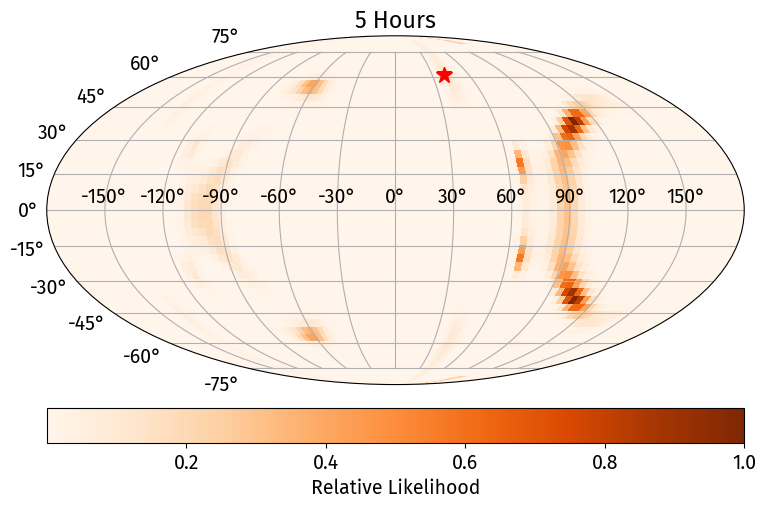

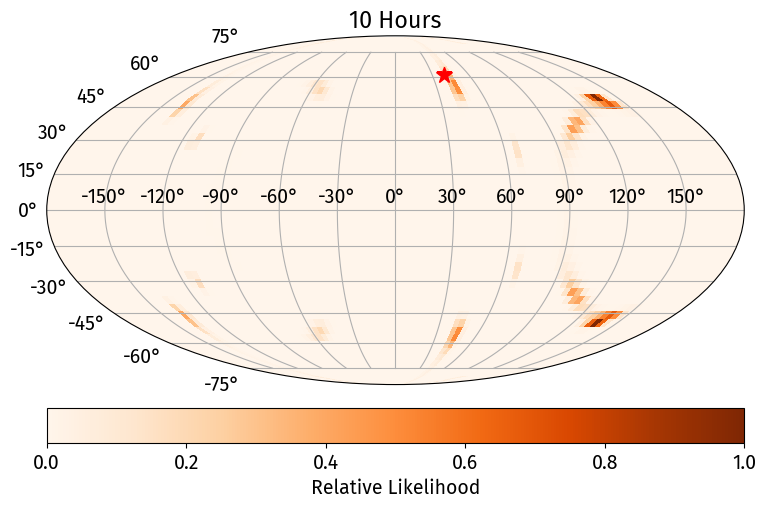

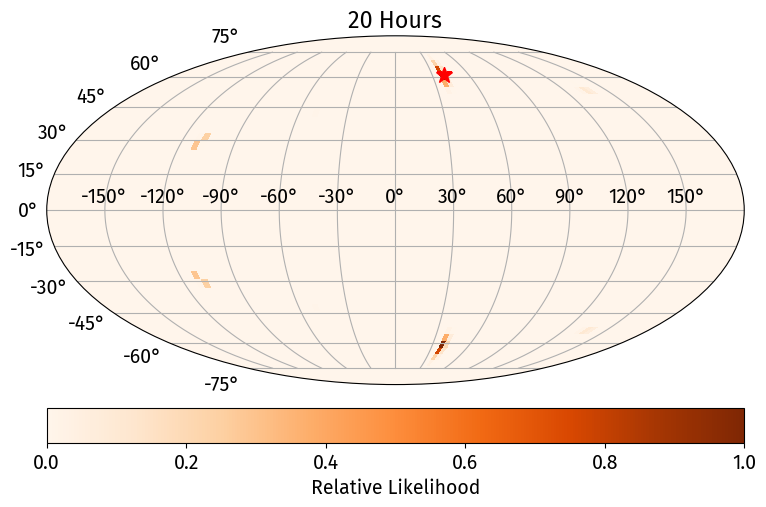

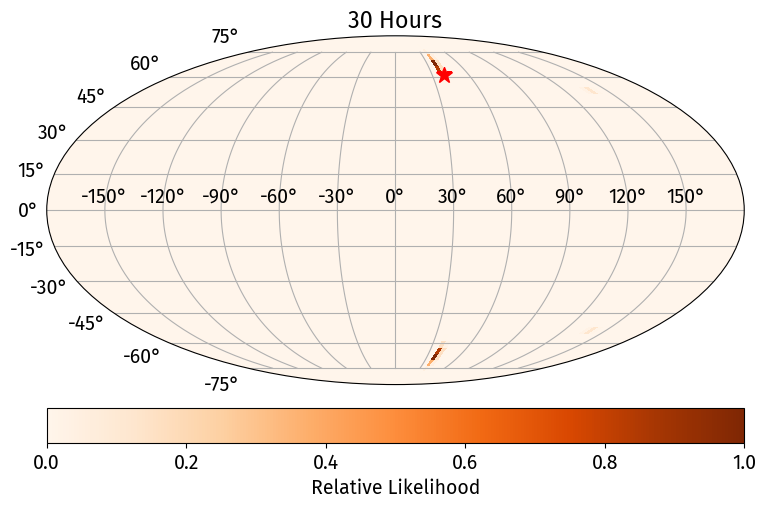

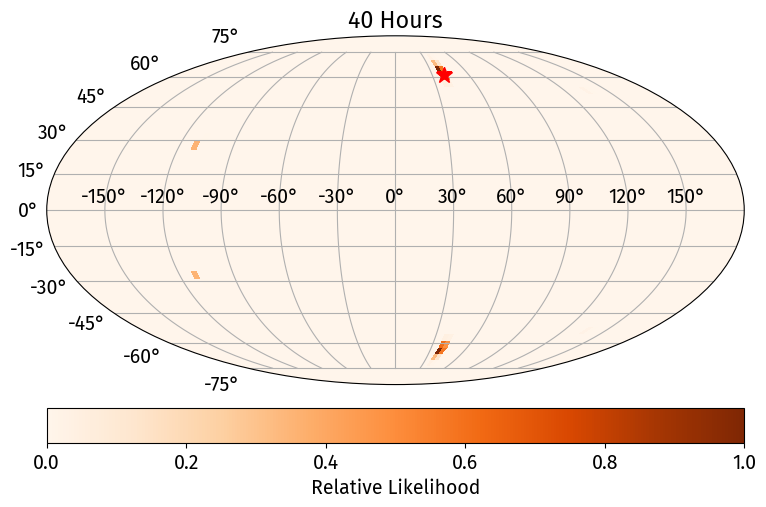

In [14]:
for measurement_hours in [5,10,20,30,40]:
    T = 160
    offset = np.pi/10
    n_points = 5
    avgs = (measurement_hours*3600/(T*n_points))

    measured_S = []
    measured_errs = []
    for s in S:
        t0,phis_measured,phis_err =estimate_phase(T,int(n_points),int(avgs),A = np.abs(s),phi = np.angle(s),N = 1e7,offset = np.pi/10)
        fit = fit_sine(t0,phis_measured,phis_err)
        measured_S.append(fit['amplitude']*np.exp(1j*fit['phase']))
        measured_errs.append(np.sqrt(fit['amplitude_err']**2+(fit['amplitude']*fit['phase_err'])**2))

    pol_ampls = {'Aplus': 1.0, 'Across': 0.0}   # only plus intrinsic

    # fake observed complex amplitudes (from matched-filter / analytic extraction)
    S_obs = np.array(measured_S)
    obs_sigma = np.array(measured_errs)
    psi = 0


    A_hat, logL = profile_likelihood_over_A0(S_obs, obs_sigma, theta_sky, phi_sky, psi,
                                             arms, pol_ampls, positions, f_gw)
    print("Best-fit complex A0:", A_hat)
    print("Profile log-likelihood:", logL)


#     theta_vals = np.linspace(0, np.pi, 50)
#     phi_vals = np.linspace(-np.pi, np.pi, 100)

#     likelihood = np.zeros((len(theta_vals), len(phi_vals)))


#     for i, theta in enumerate(theta_vals):
#             for j, phi in enumerate(phi_vals):
#                 A_hat, logL = profile_likelihood_over_A0(S_obs, obs_sigma, theta, phi, psi,
#                                              arms, pol_ampls, positions, f_gw)
#                 likelihood[i,j] =  np.exp(logL)


#     plt.figure(figsize=(8,5))
#     plt.contourf(phi_vals*180/np.pi, theta_vals*180/np.pi, likelihood, 1000, cmap='Oranges')

#     plt.xlabel("Phi [deg]")
#     plt.ylabel("Theta [deg]")
#     plt.title("%d Hours"%(measurement_hours))

#     plt.plot(phi_sky*180/np.pi, theta_sky*180/np.pi, marker='*', markersize=5, color='red', label='true_location')
    
#     # plt.contour(phi_vals*180/np.pi, theta_vals*180/np.pi,likelihood, levels = [np.max(likelihood)-2.302])
#     plt.savefig('localize_%d_hours.pdf'%(measurement_hours))
    # plt.colorbar()
    
    theta_vals = np.linspace(0, np.pi, 50)      # colatitude [0, π]
    phi_vals = np.linspace(-np.pi, np.pi, 100)  # longitude [-π, π]

    # Fill log-likelihood grid
    logL_grid = np.zeros((len(theta_vals), len(phi_vals)))
    for i, theta in enumerate(theta_vals):
        for j, phi in enumerate(phi_vals):
            A_hat, logL = profile_likelihood_over_A0(S_obs, obs_sigma, theta, phi, psi,
                                                     arms, pol_ampls, positions, f_gw)
            logL_grid[i, j] = logL

    # Normalize so max = 0 (easier for contours)
    logL_grid -= np.max(logL_grid)

    # Meshgrid for plotting
    PHI, THETA = np.meshgrid(phi_vals, theta_vals)

    # Convert colatitude θ to latitude for Mollweide
    lat = 0.5*np.pi - THETA   # θ=0 → north pole, θ=π/2 → equator
    lon = PHI                 # φ already in [-π, π]

    # Make the skymap
    fig = plt.figure(figsize=(9,6))
    ax = fig.add_subplot(111, projection="mollweide")

    # Filled map (exp for visualization, so it’s positive)
    im = ax.pcolormesh(lon, lat, np.exp(logL_grid), cmap="Oranges", shading="auto")

    # 90% confidence contour
    # CS = ax.contour(lon, lat, logL_grid, 
    #                 levels=[-2.302], colors="blue")

    # True location (convert to lat, lon)
    lat_true = 0.5*np.pi - theta_sky
    lon_true = phi_sky
    ax.plot(lon_true, lat_true, marker="*", markersize=12, color="red")

    # Tidy up
    ax.grid(True)
    fig.colorbar(im, orientation="horizontal", pad=0.05, label="Relative Likelihood")
    plt.title("%d Hours" % measurement_hours)

    plt.savefig('skymap_%d_hours.pdf' % measurement_hours)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Profile log-likelihood: -21.79384127948268


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Profile log-likelihood: -24.711912909249477


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Profile log-likelihood: -59.63749685172878


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Profile log-likelihood: -91.61541863777924


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Profile log-likelihood: -110.62686168561316


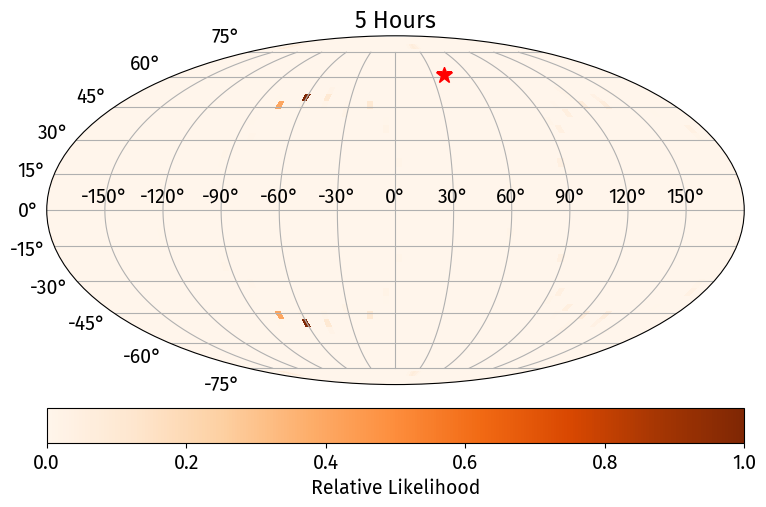

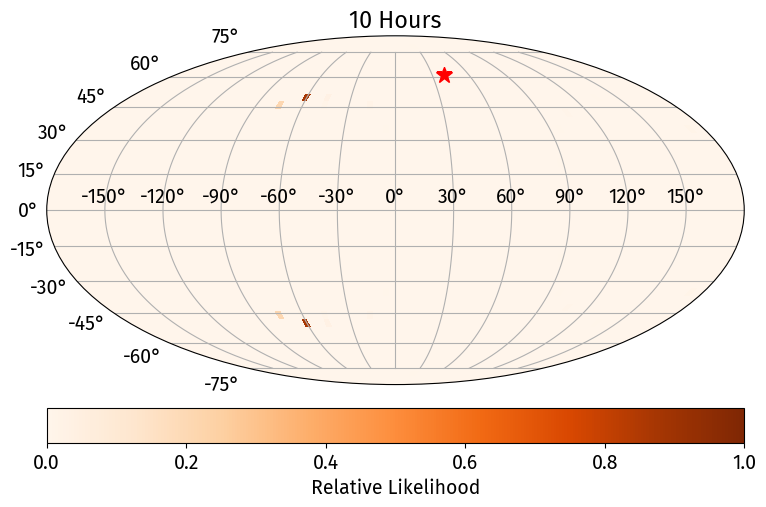

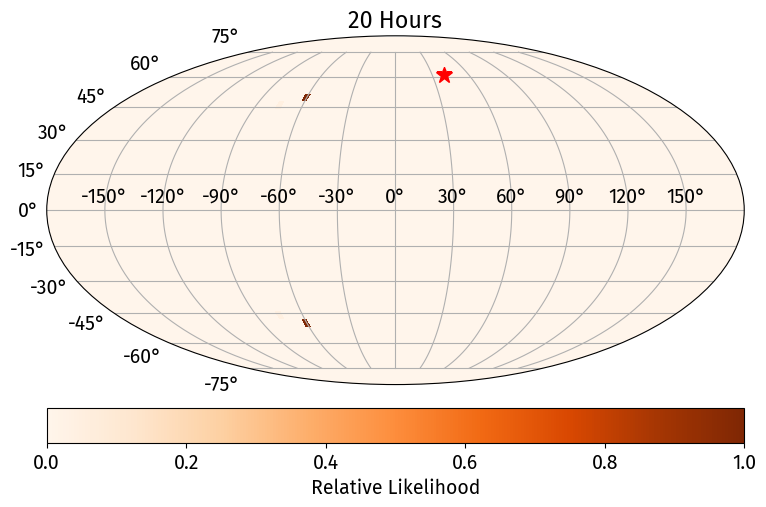

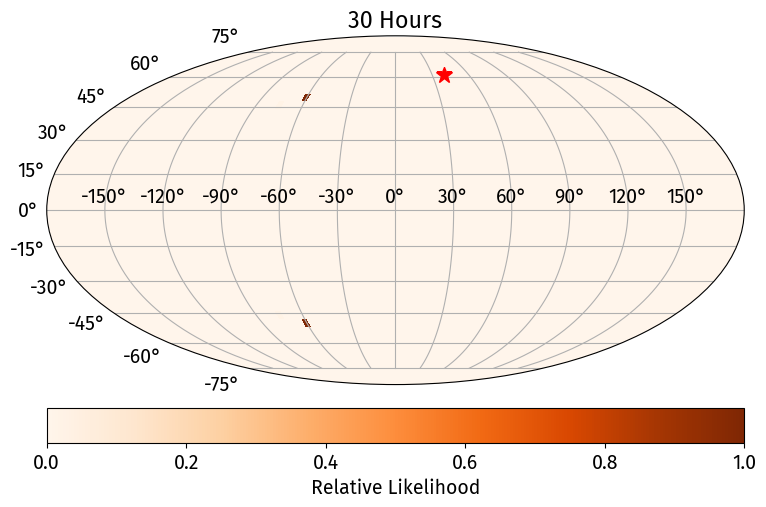

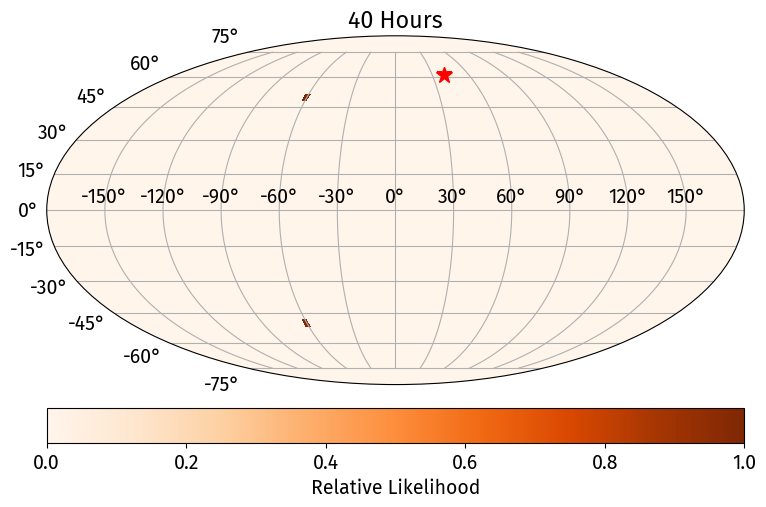

In [28]:
for measurement_hours in [5,10,20,30,40]:
    T = 160
    offset = np.pi/10
    n_points = 5
    avgs = (measurement_hours*3600/(T*n_points))

    measured_S = []
    measured_errs = []
    for s in S:
        t0,phis_measured,phis_err =estimate_phase(T,int(n_points),int(avgs),A = np.abs(s),phi = np.angle(s),N = 1e7,offset = np.pi/10)
        fit = fit_sine(t0,phis_measured,phis_err)
        measured_S.append(fit['amplitude']*np.exp(1j*fit['phase']))
        measured_errs.append(np.sqrt(fit['amplitude_err']**2+(fit['amplitude']*fit['phase_err'])**2))

    pol_ampls = {'Aplus': 1.0, 'Across': 0.0}   # only plus intrinsic

    # fake observed complex amplitudes (from matched-filter / analytic extraction)
    S_obs = np.array(measured_S)
    obs_sigma = np.array(measured_errs)
    psi = 0


    logL = marginalized_likelihood(S_obs, obs_sigma,theta=theta_sky, phi=phi_sky, psi=0.0, arms=arms, positions=positions, f_gw=f_gw)

    print("Profile log-likelihood:", logL)



    
    theta_vals = np.linspace(0, np.pi, 50)      # colatitude [0, π]
    phi_vals = np.linspace(-np.pi, np.pi, 100)  # longitude [-π, π]

    # Fill log-likelihood grid
    logL_grid = np.zeros((len(theta_vals), len(phi_vals)))
    for i, theta in enumerate(theta_vals):
        for j, phi in enumerate(phi_vals):
            logL = marginalized_likelihood(S_obs, obs_sigma,theta, phi, psi=0.0, arms=arms, positions=positions, f_gw=f_gw)
            logL_grid[i, j] = logL

    # Normalize so max = 0 (easier for contours)
    logL_grid -= np.max(logL_grid)

    # Meshgrid for plotting
    PHI, THETA = np.meshgrid(phi_vals, theta_vals)

    # Convert colatitude θ to latitude for Mollweide
    lat = 0.5*np.pi - THETA   # θ=0 → north pole, θ=π/2 → equator
    lon = PHI                 # φ already in [-π, π]

    # Make the skymap
    fig = plt.figure(figsize=(9,6))
    ax = fig.add_subplot(111, projection="mollweide")

    # Filled map (exp for visualization, so it’s positive)
    im = ax.pcolormesh(lon, lat, np.exp(logL_grid), cmap="Oranges", shading="auto")

    # 90% confidence contour
    # CS = ax.contour(lon, lat, logL_grid, 
    #                 levels=[-2.302], colors="blue")

    # True location (convert to lat, lon)
    lat_true = 0.5*np.pi - theta_sky
    lon_true = phi_sky
    ax.plot(lon_true, lat_true, marker="*", markersize=12, color="red")

    # Tidy up
    ax.grid(True)
    fig.colorbar(im, orientation="horizontal", pad=0.05, label="Relative Likelihood")
    plt.title("%d Hours" % measurement_hours)

    plt.savefig('skymap_marginalized_%d_hours.pdf' % measurement_hours)

In [51]:
S

array([0.09934016-0.08795041j, 0.24696651+0.25892441j,
       0.25979654+0.11121876j])

In [64]:
measured_S/S

array([0.0063672 +0.0051738j , 0.00654313+0.00505204j,
       0.00662754+0.00524929j])